<h1 align="center">CLEANING DATA</h1>

## Giới thiệu về bộ dữ liệu sẽ xử lý

- Bộ dữ liệu raw bao gồm 4 file `laptop_basic.csv`, `laptop_detail.csv`, `cpuben.csv` và `cpuben.csv`. Dữ liệu được cào từ website [LaptopMedia](https://laptopmedia.com/)
- File `laptop_basic.csv` chứa link thông tin của 1000 laptop.
- File `laptop_detail.csv` chứa thông tin chi tiết của 1000 laptop.
- File `cpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 122 mẫu CPU.
- File `gpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 140 mẫu GPU.
- Trong notebook này, chúng em sẽ tiến hành gộp, xử lý và làm sạch dữ liệu. Kết quả cuối cùng sẽ được lưu vào file 'clean_data.csv' 

## 1. Khai báo thư viện


In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

## 2. Load và kiểm tra tập dữ liệu thô

In [2]:
data_detail = pd.read_csv('raw10k\laptop_detail.csv')
print('Number of rows and columns:', data_detail.shape)

Number of rows and columns: (10000, 97)


In [3]:
data_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 97 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Unnamed: 0.1                                                                                10000 non-null  int64  
 1   Unnamed: 0                                                                                  10000 non-null  int64  
 2   Product Name                                                                                10000 non-null  object 
 3   Product Link                                                                                10000 non-null  object 
 4   Processor                                                                                   10000 non-null  object 
 5   Internal memory                         

In [4]:
data_detail.head(3)

,Unnamed: 0.1,Unnamed: 0,Product Name,Product Link,Processor,Internal memory,Video card,Display,Solid-state drive,Price,...,Storage drive heater\n,4G LTE multi carrier mobile broadband with satellite GPS,E-compass\n,Accelerometer,4x RAM slots,G-sensor,Accelerometer (G-sensor),Slot Integrated Bluetooth Earbuds,3W subwoofer,MIL-STD 810G tested
0,0,0,ASUS TUF Dash F15,https://laptopmedia.com/laptop-specs/asus-tuf-...,Intel Core i7-12650H,64GB RAM,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$362900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Lenovo Legion 5i 15,https://laptopmedia.com/laptop-specs/lenovo-le...,Intel Core i7-12700H,64GB RAM,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$304999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Acer Nitro 5,https://laptopmedia.com/laptop-specs/acer-nitr...,Intel Core i7-12700H,32GB RAM,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$181900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
col_nan_count = data_detail.isnull().sum()
# count number of columns with missing values
print('Number of columns with missing values:', len(col_nan_count[col_nan_count > 0]))

Number of columns with missing values: 89


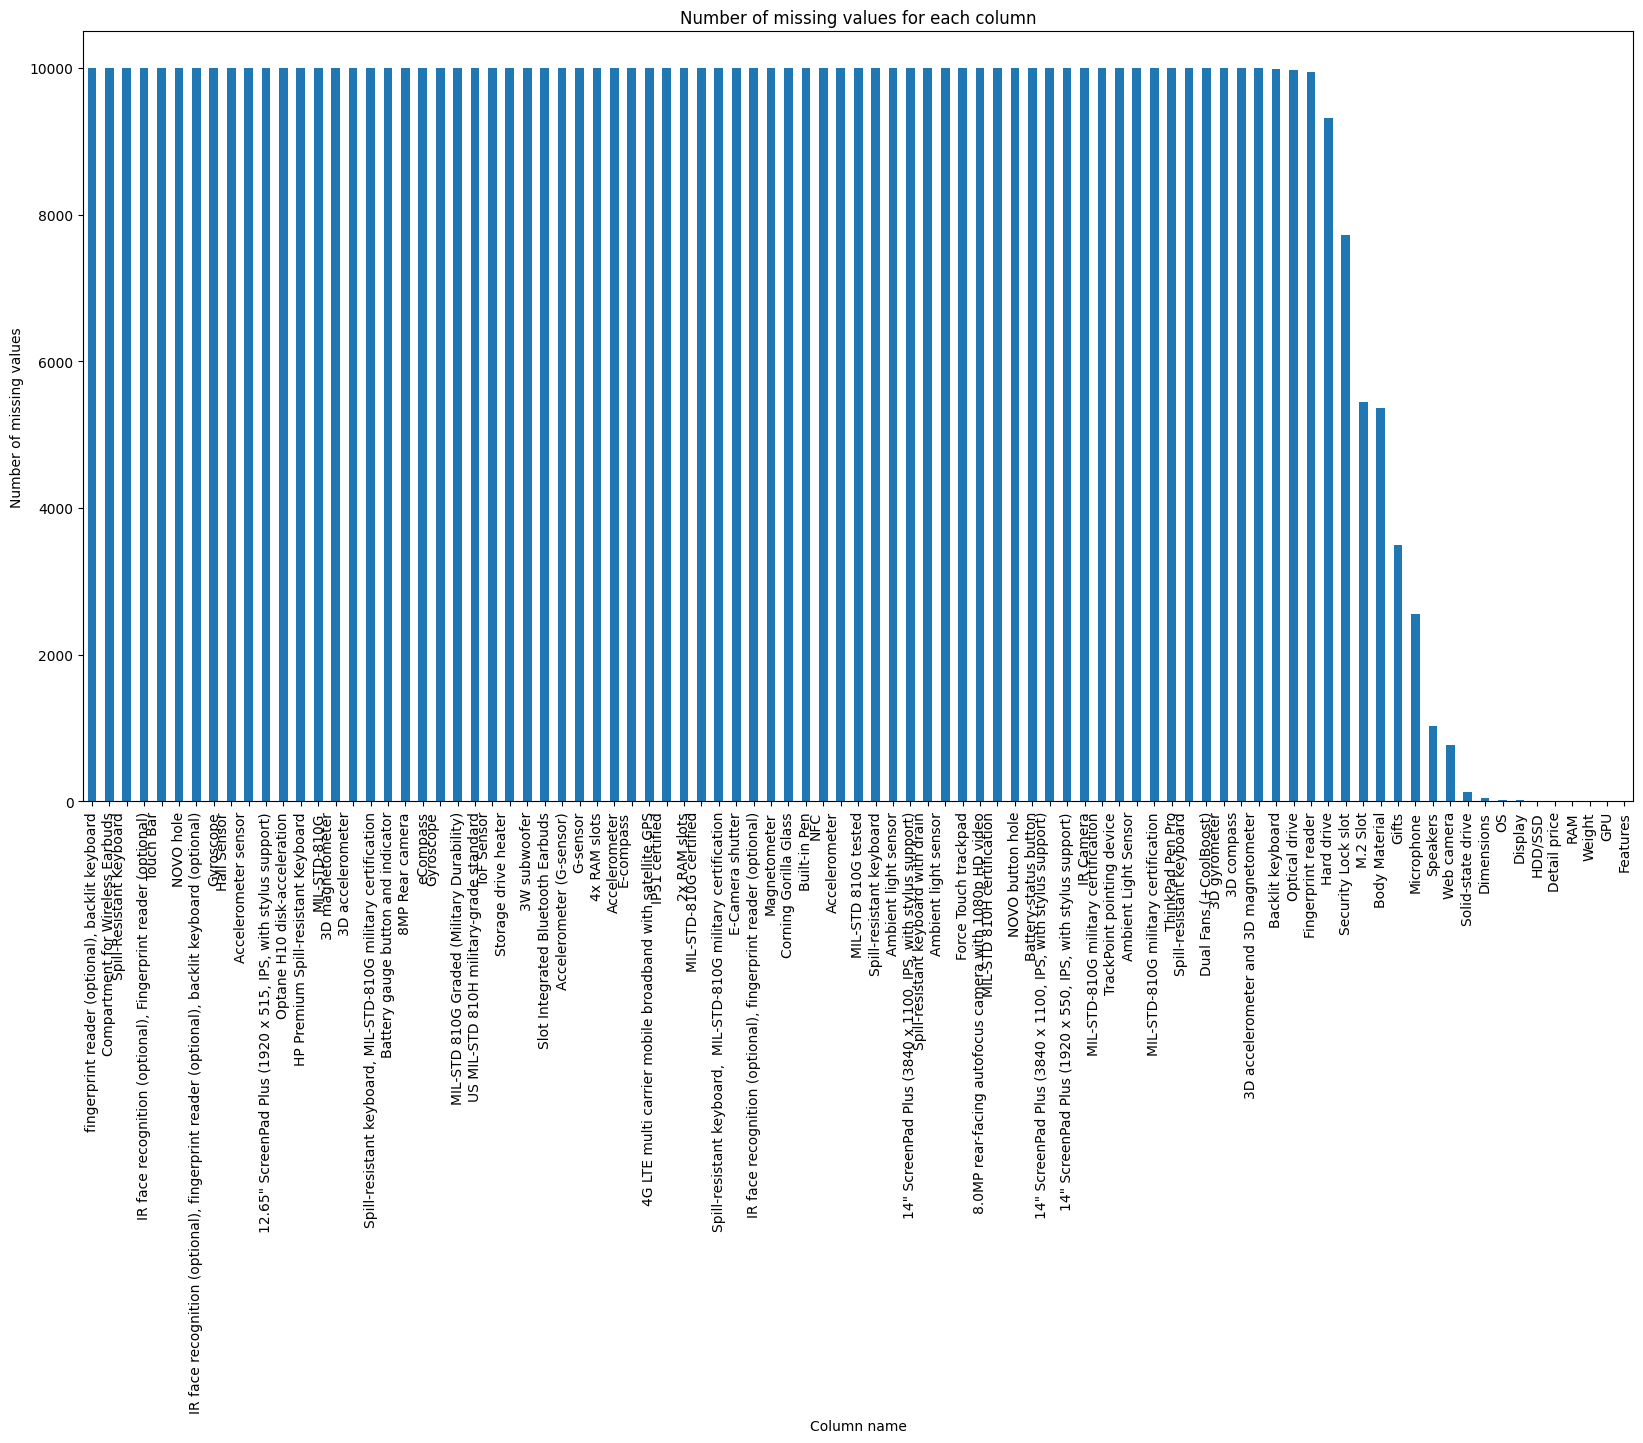

In [6]:
# plot number of missing values for each column with x axis is column name and y axis is number of missing values and sort by number of missing values
col_nan_count[col_nan_count > 0].sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
plt.title('Number of missing values for each column')
plt.xlabel('Column name')
plt.ylabel('Number of missing values')
plt.show()

## 3. Làm sạch dữ liệu

### 3.1 Xóa hai cột thông tin dư đầu tiên
Hai cột đầu tiên không chứa thông tin liên quan nên sẽ được xóa bỏ.

In [7]:
# delete the first two column
data_detail = data_detail.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

### 3.2 Xử lý dữ liệu trống, trùng lặp và không cần thiết


#### 3.2.1 Kiểm tra lại tập dữ liệu


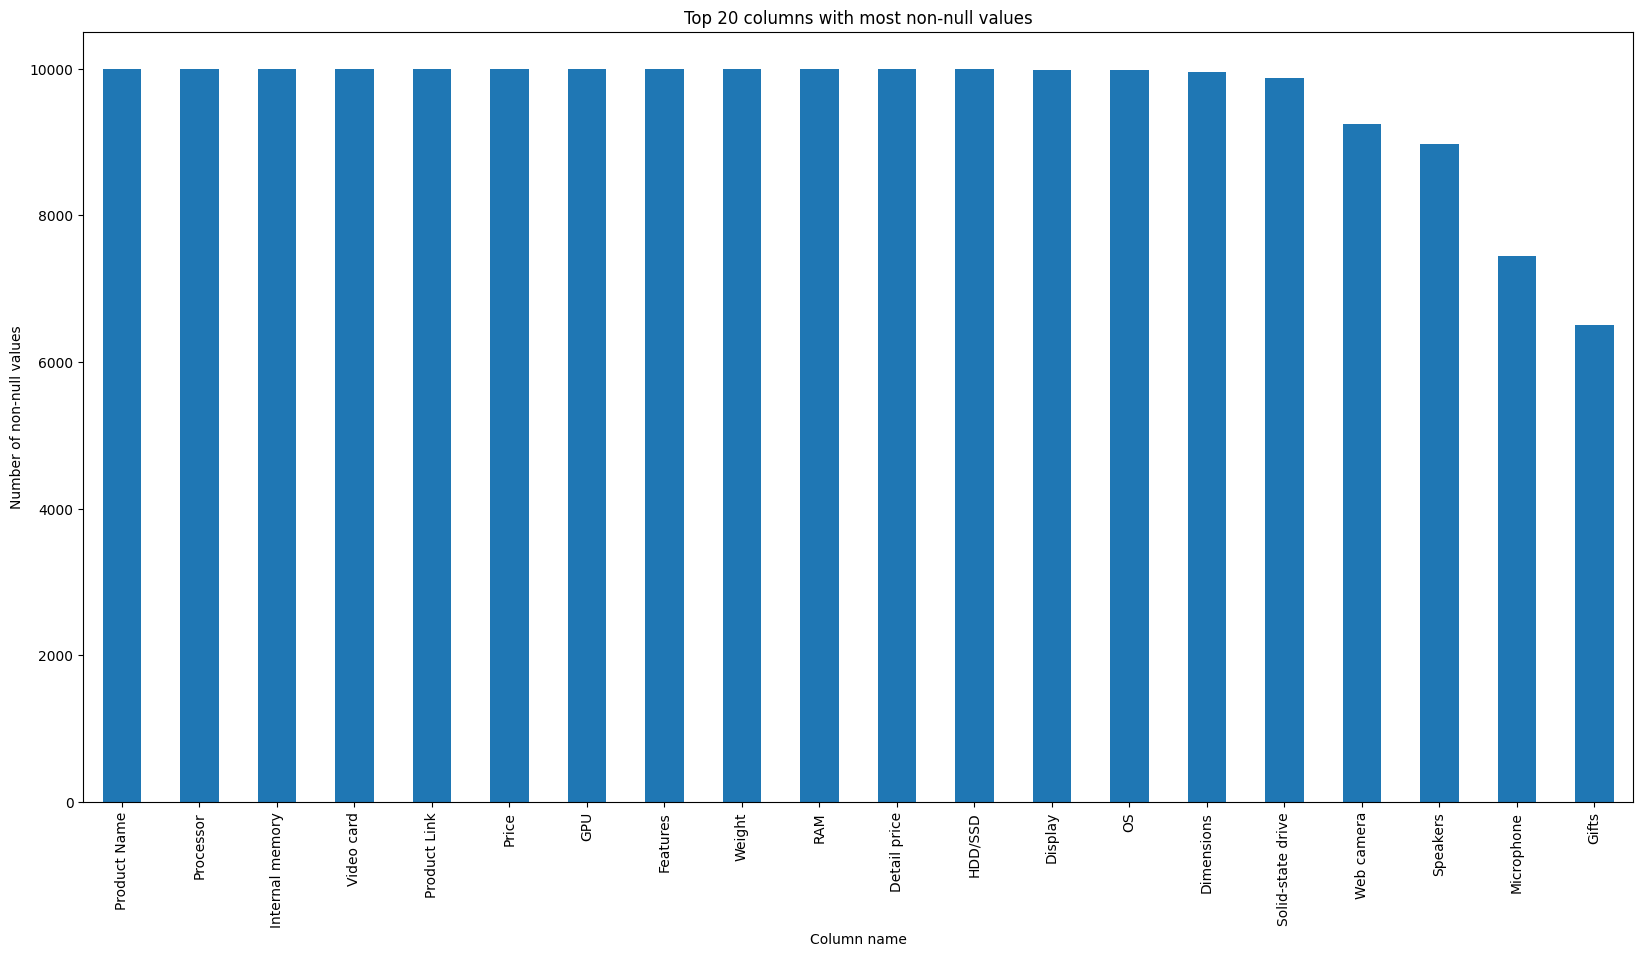

In [8]:
# plot top 20 columns with most non-null values
data_detail.count().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(20, 10))
plt.title('Top 20 columns with most non-null values')
plt.xlabel('Column name')
plt.ylabel('Number of non-null values')
plt.show()

#### 3.2.2 Xóa các cột thông tin chứa quá nhiều dữ liệu trống


- Xóa các cột mà trong đó số giá trị null chiếm hơn 20% tổng số giá trị của cột đó.

In [9]:
def filter_column_meaningless(df, percent=0.80):
    filtered_column = []
    for column in df.columns:
        if (df[column].notnull().sum() <= percent * df.shape[0]):
            filtered_column.append(column)
    return filtered_column

In [10]:
useless_column = filter_column_meaningless(data_detail)

77


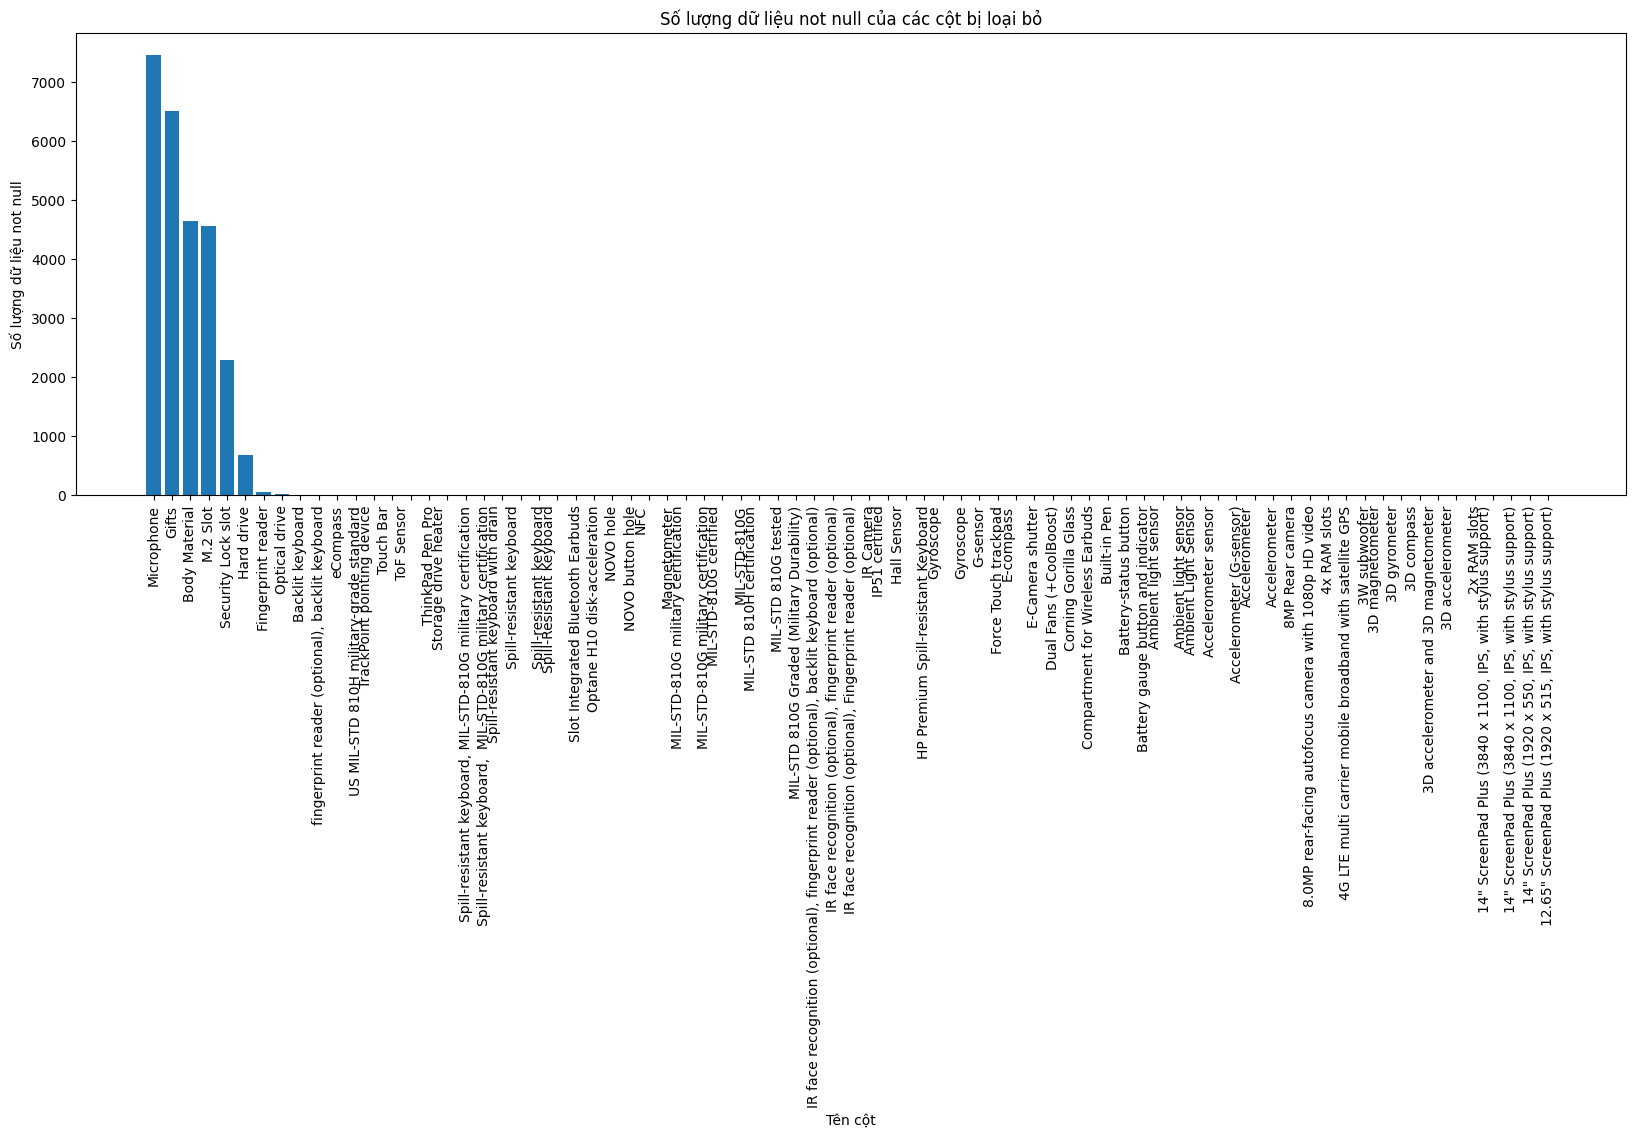

In [11]:
# print the name and number of non-null values of useless columns
print(len(useless_column))
useless_column_count = []
for column in useless_column:
    useless_column_count.append(data_detail[column].notnull().sum())

# sort the number of non-null values of useless columns
useless_column_count, useless_column = zip(*sorted(zip(useless_column_count, useless_column), reverse=True))

# plot on bar chart
plt.figure(figsize=(20, 6 ))
plt.bar(useless_column, useless_column_count)
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột bị loại bỏ')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()

In [12]:

data = data_detail.drop(columns=filter_column_meaningless(data_detail))

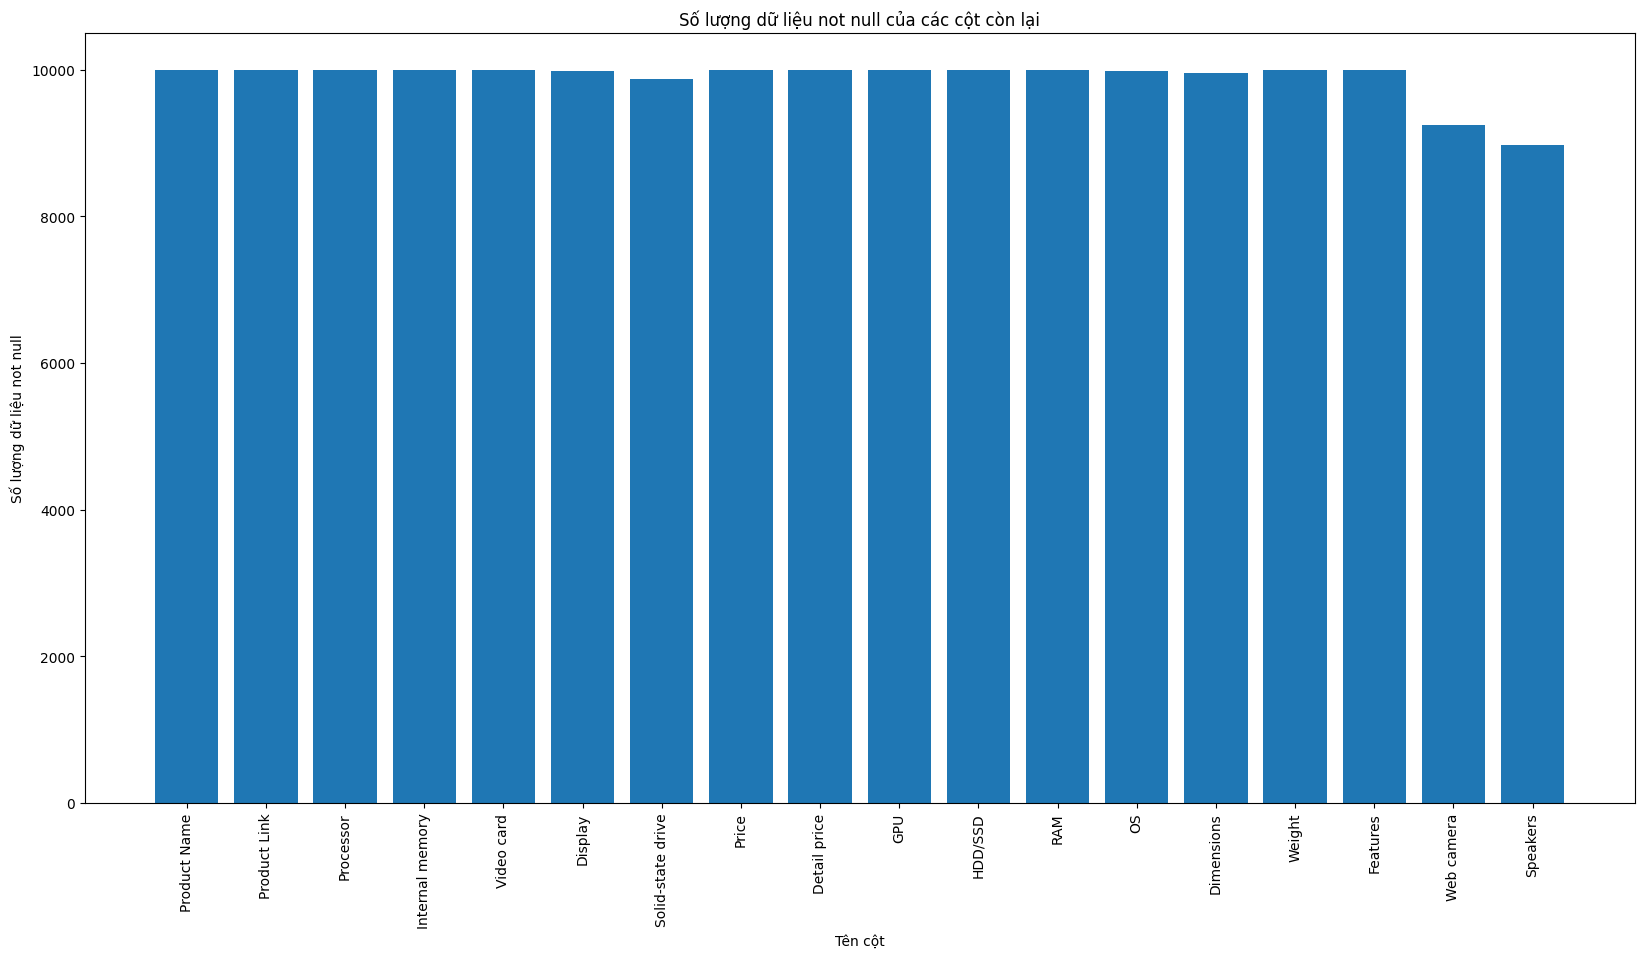

In [13]:
# plot the number of non-null values of each column
plt.figure(figsize=(20, 10))
plt.bar(data.columns, data.count())
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột còn lại')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()

#### 3.2.3 Chỉnh sửa thông tin và xóa đi các cột thông tin không cần thiết/ trùng lặp

- Giữ lại cột 'Solid-state-drive' vì dữ liệu dễ xử lý và sạch hơn cột 'HDD/SSD'. Cột 'HDD/SSD' có nhiều dữ liệu không đồng nhất do đó ta xóa cột này đi.

In [14]:
data['HDD/SSD'].unique()[:25]

array(['2TB SSD RAID 0', '2TB SSD RAID 1', '2TB SSD', '1TB SSD',
       '1TB SSD ', '8TB SSD', '4TB SSD', '512GB SSD',
       '512GB SSD + 1TB HDD', '256GB SSD + 1TB HDD', '2TB SSD + 2TB HDD',
       '256GB SSD', '2TB SSD ', '1TB SSD RAID 1', '128GB SSD',
       '32GB eMMC', '512GB PCIe NVMe SSD', '500GB HDD', '8TB SSD ',
       '128GB SSD + 1TB HDD', '1TB HDD', '64GB eMMC', '1TB SSD RAID 0',
       '128GB eMMC', '1TB SSD  + 2TB HDD'], dtype=object)

In [15]:
data = data.drop(columns='HDD/SSD')

- Đối với giá sản phẩm sẽ chỉ giữ lại cột 'Detail price' vì cột này có định dạng giá đúng. Do đó ta xóa cột price đi.


In [16]:
data = data.drop(columns='Price')

- Đối với 'RAM' và 'Internal memory' sẽ giữ lại cột 'RAM' vì định dạng dữ liệu đơn giản hơn. Do đó ta xóa cột 'Internal memory' đi.


In [17]:
data = data.drop(columns='Internal memory')

- Giữ lại cột 'Video card' vì định dạng dữ liệu đơn giản hơn cột 'GPU'.

In [18]:
data = data.drop(columns='GPU')

- Cột 'Web camera' và 'Speakers' không có nhiều thông tin (chỉ có thông tin về tên của camera và loa) nên sẽ xóa.


In [19]:
# Some web camera values
data['Web camera'].unique()[10:25]

array(['HD with camera shutter, temporal noise reduction', 'HD or FHD',
       'HD / FHD / IR with privacy shutter, fixed focus', 'HD 720p',
       '5MP with IR', 'FHD with privacy shutter, fixed focus', '5MP',
       'HD TrueVision with temporal noise reduction', 'FHD & IR', 'HD IR',
       'FHD IR with Windows Hello', 'HD with privacy shutter',
       'FHD IR Camera for Windows Hello', 'HD + FHD', '2MP Full HD'],
      dtype=object)

In [20]:
# Some speaker values
data['Speakers'].unique()[10:25]

array(['2x 1.5W Stereo Speakers, Dolby Audio', '2 Speakers',
       '2x 2.5W Stereo Speakers', '4x Speakers, Smart Amp, Dolby Atmos',
       '2x 2W, DTS: X Ultra', 'Stereo Speakers',
       '2x 2W Speaker, Dynaudio', '2x Stereo Speakers, Acer TrueHarmony',
       '2x Speakers',
       ' 2x 2W Dual-Force Woofer + 2x 2W Tweeter, Smart Amp, Dolby Atmos',
       'Stereo Speakers, Bang & Olufsen, DTS:X Ultra',
       'Speaker System optimized by DTS Audio', '2x 2W, Dolby Audio',
       '2x 2W Speakers + 4x 2W Woofers, Dynaudio, Nahimic 3',
       '2x 1.5W, Dolby Atmos'], dtype=object)

In [21]:
data = data.drop(columns=['Web camera', 'Speakers'])


- Cuối cùng, xóa cột 'Product Link' vì không cần thiết.


In [22]:
data = data.drop(columns='Product Link')


### 3.3 Kiểm tra lại tập dữ liệu


In [23]:
data.head(5)

,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera


In [24]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product Name       10000 non-null  object
 1   Processor          10000 non-null  object
 2   Video card         10000 non-null  object
 3   Display            9985 non-null   object
 4   Solid-state drive  9866 non-null   object
 5   Detail price       9997 non-null   object
 6   RAM                9998 non-null   object
 7   OS                 9975 non-null   object
 8   Dimensions         9950 non-null   object
 9   Weight             9999 non-null   object
 10  Features           9999 non-null   object
dtypes: object(11)
memory usage: 859.5+ KB


## 4. Gộp và chỉnh sửa lại dữ liệu (định dạng, thông tin, đơn vị...)


### 4.1 Gộp thông tin benchmark của CPU và GPU vào data


In [25]:
data_cpu = pd.read_csv('raw10k\cpuben.csv')
data_gpu = pd.read_csv('raw10k\gpuben.csv')

In [26]:
# Merge CPU data
data = pd.merge(data, data_cpu, left_on='Processor',
                right_on='CPU', how='left')
data.rename(columns={'Rank': 'Rank CPU'}, inplace=True)


In [27]:
data = pd.merge(data, data_gpu, left_on='Video card',
                right_on='GPU', how='left')
data.rename(columns={'Rank': 'Rank GPU'}, inplace=True)


In [28]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,CPU,Cinebench23,Rank GPU,GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,Intel Core i7-12650H,13001.0,NaN,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,Intel Core i7-12700H,15486.0,35.0,"NVIDIA GeForce RTX 3060 (Laptop, 130W)",8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,Intel Core i7-12700H,15486.0,34.0,"NVIDIA GeForce RTX 3060 (Laptop, 140W)",8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,Intel Core i7-11800H,12390.0,39.0,"NVIDIA GeForce RTX 3060 (Laptop, 105W)",8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,NaN,115.0,Intel Iris Xe Graphics G7 (80EU),1097.0


Chúng ta có thể thấy rằng có một số CPU và GPU trong data không có dữ liệu. Vì vậy, chúng ta sẽ loại bỏ hai cột này khỏi data vì thông tin tương tự đã có trong cột 'Video card' và 'Processor'.


In [29]:
# Delete Processor and Video card columns
data = data.drop(columns=['CPU', 'GPU'])
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,13001.0,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,15486.0,35.0,8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,15486.0,34.0,8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,12390.0,39.0,8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,115.0,1097.0


### 4.2 Xóa dữ liệu trống và trùng lặp


- Ta sẽ xóa các hàng có giá trị null trong nhiều hơn 3 cột để đảm bảo dữ liệu mang đầy đủ thông tin cho quá trình xử lý về sau

In [30]:
# print number of rows that have missing values in more than 5 columns
print('Number of rows that have missing values in more than 3 columns:', data[data.isnull().sum(axis=1) > 3].shape[0])

Number of rows that have missing values in more than 3 columns: 512


In [31]:
# delete rows that have null values in more than 3 columns
data = data.dropna(thresh=data.shape[1] - 3)

- Xóa các dòng dữ liệu trùng lặp

In [32]:
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)

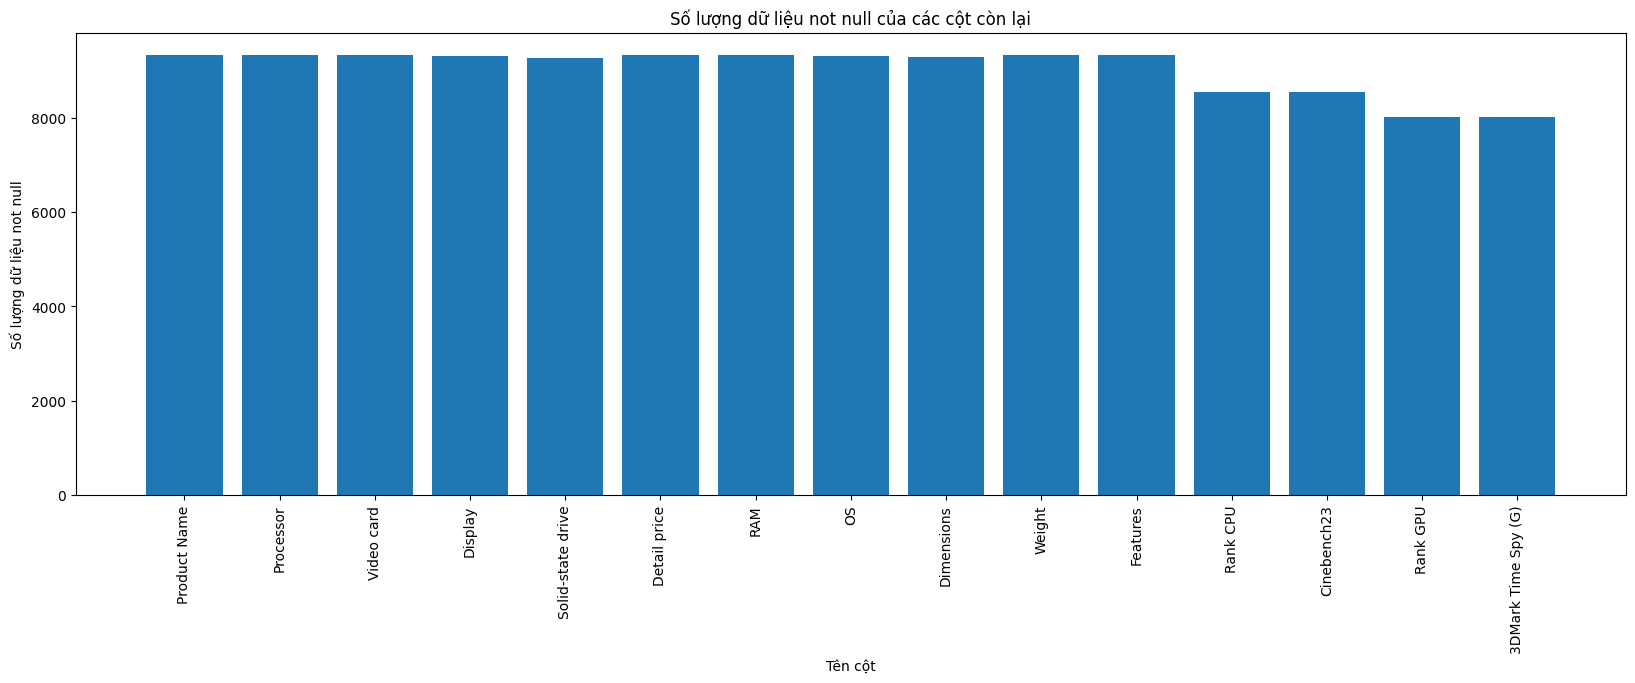

In [33]:
# print the sorted number of non-null values of each column
# plot the number of non-null values of each column
plt.figure(figsize=(20, 6))
plt.bar(data.columns, data.count())
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu not null của các cột còn lại')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu not null')
plt.show()


In [34]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,13001.0,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,15486.0,35.0,8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,15486.0,34.0,8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,12390.0,39.0,8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,115.0,1097.0


### 4.3 Chỉnh sửa lại các cột dữ liệu


- Tạo một dataframe mới để chứa dữ liệu sau khi làm sạch

In [35]:
# create new dataframe
clean_df = pd.DataFrame()

#### 4.3.1 Chỉnh sửa thông tin giá

- **Price** : giá laptop (đơn vị: USD) là thông tin được sử dụng để dự đoán. Ta chỉ giữ lại giá trị và xóa kí tự $.

In [36]:
clean_df['price'] = data['Detail price'].str.extract(r'\$(\d+.\d+)')
clean_df['price'] = clean_df['price'].astype('float64')


#### 4.3.2 Chỉnh sửa thông tin hãng sản xuất

- **Brand** : Laptop brand
- Trích xuất tên hãng từ cột 'Product Name'.


In [37]:
clean_df['brand'] = data['Product Name'].str.upper().str.split().str[0]
clean_df['brand'].unique()

array(['ASUS', 'LENOVO', 'ACER', 'HP', 'DELL', 'MSI', 'ALIENWARE', 'LG',
       'APPLE', 'SAMSUNG', 'MICROSOFT', 'AORUS', 'GIGABYTE', 'RAZER',
       'PANASONIC', 'DYNABOOK', 'ENVY'], dtype=object)

#### 4.3.3 Chỉnh sửa thông tin RAM

- **RAM** : Laptop RAM
- Trích xuất thông tin về dung lượng RAM từ cột 'RAM'.


In [38]:
clean_df['ram'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
clean_df['ram'] = clean_df['ram'].astype('float64')
clean_df['ram'].unique()


array([ 64.,  32.,  16.,  12.,   8.,  24.,  40.,   4.,  20.,  36.,  48.,
       128.,  96.,  18.,   2.])

- **RAM TYPE** : Loại RAM
- Trích xuất thông tin về loại RAM từ cột 'RAM'.


In [39]:

clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
# get text after GB and before , (comma) or nothing
clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'GB\s*(\w*)\,?')
# print numver of non-null value
clean_df['ram_type'].unique()


array(['DDR5', 'DDR4', 'LPDDR4X', 'LPDDR5', 'LPDDR4', 'RAM', 'LPDDR3',
       'DDR3', 'LPDDR2', ''], dtype=object)

In [40]:
clean_df['ram_type'].value_counts()

ram_type
DDR4       6984
DDR5       1480
LPDDR5      388
LPDDR4X     363
LPDDR4       62
RAM          35
LPDDR3       10
DDR3          3
LPDDR2        1
              1
Name: count, dtype: int64

Ta thấy không có loại ram nào có tên loại là RAM, điều này có thể vì dữ liệu cào không sạch, ta thấy số record có 'ram_type' là 'RAM' là 1. Vì vậy, ta sẽ xóa các record này.

In [41]:
# delete rows with ram_type is 'RAM'
clean_df = clean_df[clean_df['ram_type'] != 'RAM']

#### 4.3.4 Chỉnh sửa thông tin về màn hình laptop

- **Display Resolution** : Laptop display resolution
- Từ các dòng dữ liệu: "15.6”, Full HD (1920 x 1080), 144 Hz, IPS" trong cột 'Display' ta trích xuất ra thêm các thuộc tính: 
    - **'display_size'** : Kích thước màn hình laptop (inch)
    - **'display_type'** : Loại màn hình laptop (HD, Full HD, 4K, OLED, ...)
    - **'screen_rate'** : Tần số làm tươi màn hình laptop (Hz)
    - **'screen_panel'** : Loại panel màn hình laptop (IPS, TN, OLED, ...)


In [42]:
# tìm kiếm kích thước màn hình
clean_df['display_size'] = data['Display'].str.extract(r'^(\d+\.?\d+)')
clean_df['display_size'] = clean_df['display_size'].astype('float64')

clean_df['display_type'] = data['Display'].str.extract(r'[,](.*?)[(]')

clean_df['resolution'] = data['Display'].str.extract(r'\((.*?)\)')

clean_df['screen_rate'] = data['Display'].str.extract(r'[)][,](.*?)[H]')

clean_df['screen_panel'] = data['Display'].str.split(',').str[-1]
# remove space at the beginning and end of the string
clean_df['screen_panel'] = clean_df['screen_panel'].str.strip()


In [43]:
# print unique value of screen_panel
clean_df['screen_panel'].value_counts()

screen_panel
IPS                         7472
TN                          1566
OLED                         235
PixelSense (2256 x 1504)       3
Full HD (1920 x 1080)          2
Name: count, dtype: int64

In [44]:
clean_df['screen_panel'].unique()

array(['IPS', 'TN', 'OLED', 'PixelSense (2256 x 1504)', nan,
       'Full HD (1920 x 1080)'], dtype=object)

Ta thấy một số record PixelSense (2256 x 1504) Full HD (1920 x 1080) ở đây, có nghĩa là những dòng này trong dữ liệu gốc không có dữ liệu về tấm nên, do đó ta xóa các record này đi

In [45]:
# delete rows with screen_panel is 'PixelSense (2256 x 1504)'
clean_df = clean_df[clean_df['screen_panel'] != 'PixelSense (2256 x 1504)']
# delete rows with screen_panel is 'Full HD (1920 x 1080)'
clean_df = clean_df[clean_df['screen_panel'] != 'Full HD (1920 x 1080)']

- Loại bỏ khoảng trắng trong cột 'screen_rate' và chuyển đổi sang kiểu số.

In [46]:
clean_df['screen_rate'] = clean_df['screen_rate'].str.strip()
clean_df['screen_rate'] = clean_df['screen_rate'].astype('float64')
clean_df['screen_rate'].unique()


array([144., 165.,  nan, 240., 120., 360., 300.,  90., 480.])

In [47]:
clean_df['display_type'].unique()

array([' Full HD ', ' QHD ', ' WQXGA ', ' HD ', ' FHD+ ', ' HD+ ',
       '  QHD ', ' WQHD ', ' WQUXGA ', ' QHD+ ', ' WUXGA ', ' WQXGA\xa0',
       ' 4K UHD ', ' WQUXGA\xa0', ' 2.5K ', ' FHD ', ' 2.2K ', ' 2.8K ',
       ' PixelSense ', ' 3.2K ', ' 3.5K ', ' UHD+ ', nan, ' 3K ',
       ' 3K2K ', ' 2K ', ' ', ' WUXGA+ ', ' WQHD+ ', ' 4K UHD+ '],
      dtype=object)

Chúng ta có thể thấy cột display_type chưa được loại bỏ khoảng trắng và ký tự đặc biệt. Vì vậy, chúng ta sẽ loại bỏ khoảng trắng và ký tự đặc biệt trong cột này. \xa0 = space

In [48]:
# trim space before and after string in display_type
clean_df['display_type'] = clean_df['display_type'].str.strip()
# change value 'Full HD' to 'FHD'
clean_df['display_type'] = clean_df['display_type'].str.replace('Full HD', 'FHD')
clean_df['display_type'].unique()


array(['FHD', 'QHD', 'WQXGA', 'HD', 'FHD+', 'HD+', 'WQHD', 'WQUXGA',
       'QHD+', 'WUXGA', '4K UHD', '2.5K', '2.2K', '2.8K', 'PixelSense',
       '3.2K', '3.5K', 'UHD+', nan, '3K', '3K2K', '2K', '', 'WUXGA+',
       'WQHD+', '4K UHD+'], dtype=object)

#### 4.3.5 Chỉnh sửa thông tin về kích thước laptop

- **Dimmension** : 358.9 x 228 x 18.4 mm -> kích thước của laptop bao gồm chiều dài, chiều rộng và độ dày (mm)


In [49]:
dimention = data['Dimensions'].str.findall(r'(\d+\.?\d+)')
# clean_df['length'] the first number in dimention
clean_df['length'] = dimention.str[0]
# clean_df['width'] the second number in dimention
clean_df['width'] = dimention.str[1]
# clean_df['height'] the third number in dimention
clean_df['thickness'] = dimention.str[2]


In [50]:
# convert to float
clean_df['length'] = clean_df['length'].astype('float64')
clean_df['width'] = clean_df['width'].astype('float64')
clean_df['thickness'] = clean_df['thickness'].astype('float64')

#### 4.3.6 Chỉnh sửa thông tin về hãng CPU và GPU

- **Processor** : CPU of laptop
- Ta trích xuất thông tin hãng sản xuất CPU và GPU từ cột 'Processor' và 'Video card'.


In [51]:
clean_df['cpu_brand'] = data['Processor'].str.split().str[0]
clean_df['cpu_brand'].unique()


array(['Intel', 'AMD', 'Apple', 'Snapdragon'], dtype=object)

- **GPU** : Laptop graphic card


In [52]:
clean_df['gpu_brand'] = data['Video card'].str.upper().str.split().str[0]
clean_df['gpu_brand'].unique()


array(['NVIDIA', 'INTEL', 'AMD', 'APPLE', 'QUALCOMM'], dtype=object)

#### 4.3.7 Chỉnh sửa thông tin về bộ nhớ trong SSD và HDD

- **Bộ nhớ trong SSD**
- Ta trích xuất dung lượng bộ nhớ trong từ cột SSD.


In [53]:
clean_df['ssd'] = data['Solid-state drive'].str.extract(r'(\d+)\s*GB')
clean_df['ssd'] = clean_df['ssd'].astype('float64')
clean_df['ssd'].unique()


array([ 2000.,  1000.,  8000.,  4000.,   512.,   256.,   128.,    32.,
          nan,    64.,   516.,  7600.,    24.,  3000.,   120.,   250.,
       10000.,    16.,  1500., 16000., 12000.,   500.])

#### 4.3.8 Chỉnh sửa thông tin về hệ điều hành

- **OS**
- Ta trích xuất thông tin về hệ điều hành từ cột OS


In [54]:
clean_df['os'] = data['OS'].str.extract(
    r'(Windows|Linux|No OS|Mac OS|Chrome OS)')

#### 4.3.9 Chỉnh sửa thông tin về cân nặng laptop

- **Weights**
- Ta trích xuất cân nặng của laptop theo đơn vị Kg.


In [55]:
clean_df['weight'] = data['Weight'].str.extract(r'^(\d+\.?\d+)')
clean_df['weight'] = clean_df['weight'].astype('float64')

#### 4.3.10 Chỉnh sửa thông tin về xếp hạng và điểm hiệu năng của CPU và GPU

- CPU/ GPU benchmark
- Ta đổi tên cột và chuyển dữ liệu sang kiểu float 64

In [56]:
clean_df['cpu_point'] = data['Cinebench23']
clean_df['gpu_point'] = data['3DMark Time Spy (G)']

# convert to float
clean_df['cpu_point'] = clean_df['cpu_point'].astype('float64')
clean_df['gpu_point'] = clean_df['gpu_point'].astype('float64')


#### 4.3.11 Chỉnh sửa thông tin về các chức năng khác của laptop

- **Features**
- Cột features chứa các tính năng khác của laptop, do đó ta không cần chỉnh sửa

In [57]:
clean_df['features'] = data['Features']
clean_df['features'].value_counts()


features
Fingerprint reader    7320
Web camera            1945
Microphone              12
Backlit keyboard        10
Name: count, dtype: int64

#### 4.3.12 Chỉnh sửa các cột dữ liệu dạng string thành uppercase

- Để dữ liệu được đồng bộ, ta sẽ chuyển các cột dữ liệu dạng string thành uppercase

In [58]:
# conver brand, ram_type, display_type, screen_panel, cpu_brand, gpu_brand, OS to uppercase
clean_df['brand'] = clean_df['brand'].str.upper()
clean_df['ram_type'] = clean_df['ram_type'].str.upper()
clean_df['display_type'] = clean_df['display_type'].str.upper()
clean_df['screen_panel'] = clean_df['screen_panel'].str.upper()
clean_df['cpu_brand'] = clean_df['cpu_brand'].str.upper()
clean_df['gpu_brand'] = clean_df['gpu_brand'].str.upper()
clean_df['os'] = clean_df['os'].str.upper()
clean_df['features'] = clean_df['features'].str.upper()


#### 4.3.13 Xóa dữ liệu trống và trùng lặp một lần nữa

- Vì chúng ta tiến hành dự đoán giá laptop, do đó, chúng ta sẽ xóa các dòng dữ liệu có giá trị 'Price' là NaN.
- Sau đó xóa các dòng trùng lặp thông tin và reset lại index

In [59]:
# drop missing value in Price column
clean_df.dropna(subset=['price'], inplace=True)

# clean_df.dropna(inplace=True)
clean_df.drop_duplicates(inplace=True)
# reset index column
clean_df.reset_index(drop=True, inplace=True)


## 5. Kiểm tra lại và lưu dữ liệu

In [60]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         8636 non-null   float64
 1   brand         8636 non-null   object 
 2   ram           8636 non-null   float64
 3   ram_type      8636 non-null   object 
 4   display_size  8622 non-null   float64
 5   display_type  8622 non-null   object 
 6   resolution    8622 non-null   object 
 7   screen_rate   2667 non-null   float64
 8   screen_panel  8622 non-null   object 
 9   length        8592 non-null   float64
 10  width         8588 non-null   float64
 11  thickness     8588 non-null   float64
 12  cpu_brand     8636 non-null   object 
 13  gpu_brand     8636 non-null   object 
 14  ssd           8579 non-null   float64
 15  os            8617 non-null   object 
 16  weight        8636 non-null   float64
 17  cpu_point     7900 non-null   float64
 18  gpu_point     7462 non-null 

In [61]:
clean_df.head()


,price,brand,ram,ram_type,display_size,display_type,resolution,screen_rate,screen_panel,length,width,thickness,cpu_brand,gpu_brand,ssd,os,weight,cpu_point,gpu_point,features
0,3629.00,ASUS,64.0,DDR5,15.6,FHD,1920 x 1080,144.0,IPS,354.00,251.00,19.90,INTEL,NVIDIA,2000.0,WINDOWS,2.00,13001.0,NaN,FINGERPRINT READER
1,3049.99,LENOVO,64.0,DDR5,15.6,QHD,2560 x 1440,165.0,IPS,358.80,262.35,19.99,INTEL,NVIDIA,2000.0,WINDOWS,2.40,15486.0,8841.0,FINGERPRINT READER
2,1819.00,ACER,32.0,DDR5,15.6,FHD,1920 x 1080,144.0,IPS,360.40,271.10,25.90,INTEL,NVIDIA,2000.0,WINDOWS,2.50,15486.0,8864.0,FINGERPRINT READER
3,2359.99,ACER,32.0,DDR4,16.0,WQXGA,2560 x 1600,165.0,IPS,358.14,261.62,19.81,INTEL,NVIDIA,1000.0,WINDOWS,2.44,12390.0,8290.0,FINGERPRINT READER
4,1309.99,HP,64.0,DDR4,15.6,HD,1366 x 768,NaN,TN,358.00,242.00,17.90,INTEL,INTEL,2000.0,WINDOWS,1.70,NaN,1097.0,WEB CAMERA


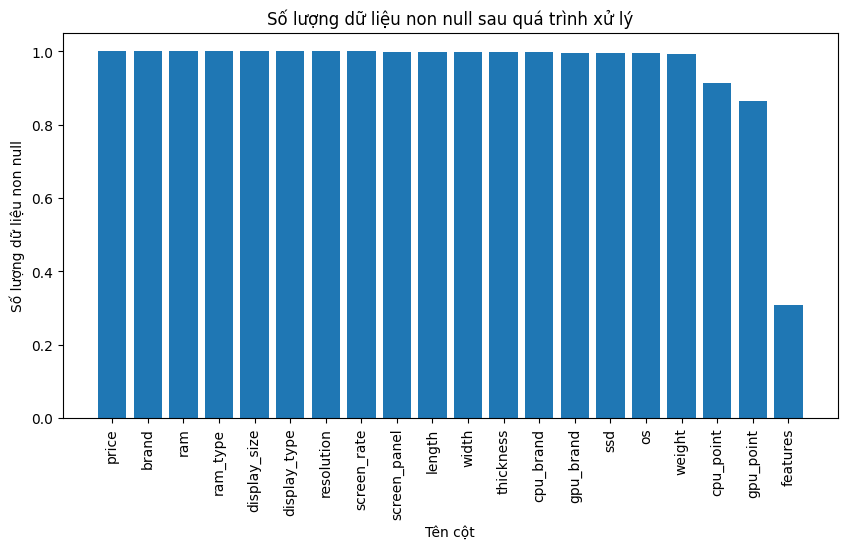

In [62]:
# plot bar chart of number of non-null value in each column
plt.figure(figsize=(10, 5))
# plot percentage of non-null value in each column and sort by value ascending
plt.bar(clean_df.columns, clean_df.notnull().mean().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.title('Số lượng dữ liệu non null sau quá trình xử lý')
plt.xlabel('Tên cột')
plt.ylabel('Số lượng dữ liệu non null')
plt.show()


- Lưu lại dữ liệu đã làm sạch

In [63]:
clean_df.to_csv('clean_data_10k.csv', index=False)
